<a href="https://colab.research.google.com/github/lakhanrajpatlolla/aiml-learning/blob/master/U3W14_49_Fingerprint_Autoencoder_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint


## Learning Objectives





At the end of the experiment, you will be able to learn:
*  reconstructing images using convolutional autoencoder.




In [ ]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="854" height="480" controls>
  <source src="https://cdn.exec.talentsprint.com/non-processed/Reconstruction_of_Images_Walkthrough.mp4" type="video/mp4">
</video>
""")

## Dataset

### Description

The fingerprint dataset has 320 images, 80 images per sensor and each sensor have varying image sizes. It consists of 4 different sensors fingerprints namely :

* Low-cost Optical Sensor
* Low-cost Capacitive Sensor
* Optical Sensor
* Synthetic Generator





### Autoencoder

An autoencoder is made up of two components- the encoder and decoder network. The task of the encoder is to generate a lower dimensional embedding Z, which is referred to latent vector, or latent representation. After that, we have the decoder stage in which Z is reconstructed to X' prime, which is the same as X (input).


![alt text](https://cdn.talentsprint.com/aiml/Experiment_related_data/IMAGES/6.png)






### Setup Steps:

In [1]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "2418775" #@param {type:"string"}

In [2]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "9959000490" #@param {type:"string"}

In [3]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython
import re
ipython = get_ipython()

notebook= "U3W14_49_Fingerprint_Autoencoder_C" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    from IPython.display import HTML, display
    ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Fingerprints.zip")
    ipython.magic("sx unzip /content/Fingerprints.zip")
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getWalkthrough() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook, "feedback_walkthrough":Walkthrough ,
              "feedback_experiments_input" : Comments,
              "feedback_inclass_mentor": Mentor_support}

      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://learn-iiith.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


def getWalkthrough():
  try:
    if not Walkthrough:
      raise NameError
    else:
      return Walkthrough
  except NameError:
    print ("Please answer Walkthrough Question")
    return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError
    else:
      return Answer
  except NameError:
    print ("Please answer Question")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


## Importing Required Packages

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tifffile import imread
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

## Load the  data

#### About glob.iglob:

The glob library  provides methods for traversing the file system and returning files that matched a defined set of glob patterns.

**Note:** Refer to  [glob.iglob](https://docs.python.org/3/library/glob.html)

In [5]:
data = glob('/content/fingerprints/DB*/*')
images = []
for i in range(len(data)):

    # Reading the data using imread
    img = imread(data[i])

    # Resize the images to 224 * 224 as the images are of different sizes
    img = resize(img,(224,224))

    # Appending all the images
    images.append(img)

# Converting the images into float32 array
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')
print("Dataset:", images_arr.shape)# The data has a shape of 320 x 224 x 224 since there are 320 samples each of the 224 x 224-dimensional matrix.

Dataset: (320, 224, 224)


## Visualizing the Images

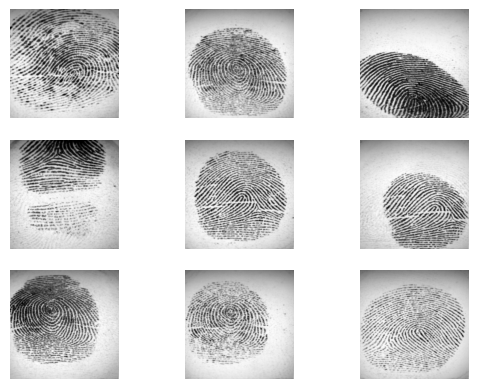

In [6]:
# Display the first 9 images in the dataset
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.axis('off')
  plt.imshow(images_arr[i], cmap="gray")

## Data Preparation

The images are in grayscale with a dimension of 224 X 224 and the number of channels for grayscale image is '1'. Reshaping the input array into four dimensions to feed into the Neural Network, which is 320 X 1 X 224 X 224 (nsamples, nchannels, height, width)

In [7]:
images_arr = images_arr.reshape(-1, 1, 224, 224)
print(images_arr.shape)

(320, 1, 224, 224)


## Split the data into training and a validation set.

In [8]:
from sklearn.model_selection import train_test_split
# Training images both act as the input as well as the ground truth similar to the labels have in the classification task
train_X,valid_X,train_ground,valid_ground = train_test_split(images_arr,images_arr,test_size=0.2,random_state=13)
train_X.shape,valid_X.shape,train_ground.shape,valid_ground.shape

((256, 1, 224, 224), (64, 1, 224, 224), (256, 1, 224, 224), (64, 1, 224, 224))

In [9]:
# To convert numpy to tensor, load the data using tensordataset and convert the values to FloatTensor
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(train_X),torch.FloatTensor(train_ground))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(valid_X),torch.FloatTensor(valid_ground))

# Loading the train dataset aand test dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

**Initializing CUDA**

CUDA is used as an interface between our code and the GPU.

Normally, we run the code in the CPU. To run it in the GPU, we need CUDA. Check if CUDA is available:

In [10]:
# To test whether GPU instance is present in the system or not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

Using PyTorch version: 2.5.1+cu124 CUDA: True


If it's False, the code is runining on CPU. If it's True, the code is runinng  on GPU.

Let us initialize some GPU-related variables:

In [11]:
device  =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Defining the Convolutional Autoencoder Architecture

Define the Convolutional Autoencoder as a class where the encoding network component is made up of two convolutional layers to compress the data. Decoding network component is made up of two convolutional layers. Each layer output in encoding and decoding network are passed through Relu activation function in the forward function.




The autoencoder is divided into two parts:

**Encoder**

The first layer will have 32 output channels with filter size 2 x 2

The second layer will have 64 output channels with filter size 3 x 3, followed by a downsampling (max-pooling) layer,



**Decoder**

The first layer will have 32 output channels with filter size size 3 x 3

The second layer will have 1 output channels with filter size size 2 x 2




In [12]:
# Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        # Defining the convolution layer with input_channels = 1, output_channels = 32, kernel_size = 2, padding =1
        self.conv1 = nn.Conv2d(1, 32, 2, padding=1)
        # Defining the convolution layer with input_channels = 32, output_channels = 64, kernel_size = 3, padding =1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Max pooling layer with filter size 2x2
        self.pool = nn.MaxPool2d(2, 2)


        # Decoder
        # Defining the convolution layer with input_channels = 64, output_channels = 32, kernel_size = 3, stride =2
        self.t_conv1 = nn.ConvTranspose2d(64, 32, 3, stride=2)
        # Defining the convolution layer with input_channels = 32, output_channels = 1, kernel_size = 2, stride =2
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)


    def forward(self, x):
        # Linear layers with RELU activation
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))

        x = F.relu(self.t_conv1(x))
        x = self.pool(x)
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))

        return x


#### Calling the instances of the network

In [13]:

#Instantiate the model
model = ConvAutoencoder().to(device)
summary(model,(1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 225, 225]             160
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
   ConvTranspose2d-4         [-1, 32, 225, 225]          18,464
         MaxPool2d-5         [-1, 32, 112, 112]               0
   ConvTranspose2d-6          [-1, 1, 224, 224]             129
Total params: 37,249
Trainable params: 37,249
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 37.35
Params size (MB): 0.14
Estimated Total Size (MB): 37.69
----------------------------------------------------------------


#### Defining the loss function and optimizer

In [14]:
# Initialization of Mean Square Error
loss_func = nn.MSELoss()

# Initialization of Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

### Training the Model

Applying Autoencoders on the train data and finding the loss on the train dataset

Note : If the loss is not changing then do the factory reset the runtime

In [15]:
EPOCH = 10
for epoch in range(EPOCH):
    for x, y in train_loader:
        t_x = x.to(device)
        t_y = y.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Passing the data to the model (Forward Pass)
        decoded1 = model(t_x)

        # Calculating mean square error loss
        loss = loss_func(decoded1, t_y)
        train_loss = loss.item()

        # Performing backward pass (Backpropagation)
        loss.backward()

        # optimizer.step() updates the weights accordingly
        optimizer.step()
    print('Epoch: ', epoch, '| train loss: %.4f' % train_loss)

Epoch:  0 | train loss: 0.0484
Epoch:  1 | train loss: 0.0278
Epoch:  2 | train loss: 0.0177
Epoch:  3 | train loss: 0.0170
Epoch:  4 | train loss: 0.0147
Epoch:  5 | train loss: 0.0132
Epoch:  6 | train loss: 0.0121
Epoch:  7 | train loss: 0.0108
Epoch:  8 | train loss: 0.0093
Epoch:  9 | train loss: 0.0080


### Evaluate the Model

Applying Autoencoders on the test data and finding the loss on the test dataset

In [16]:
# Keeping the network in evaluation mode
model.eval()
for x, y in test_loader:
  # Convert the images and labels to gpu for faster execution
  eval_x = x.to(device)
  eval_y = y.to(device)
  # Passing the data to the model (Forward Pass)
  decoded2 = model(eval_x)
   # Calculating mean square error loss
  loss = loss_func(decoded2, eval_y)
print(loss)

tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)


### Visualizing the reconstruct images of the test data.

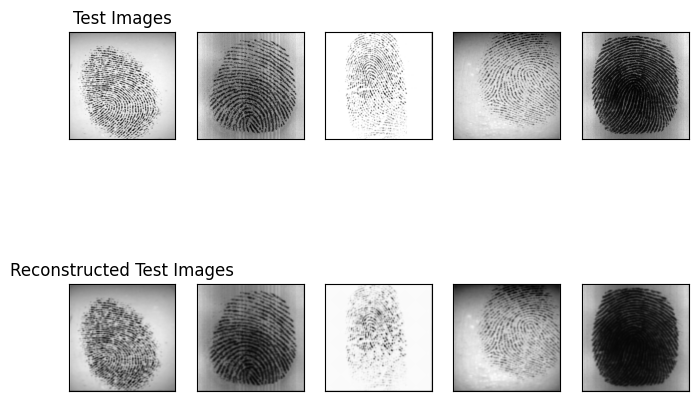

In [17]:
f, a = plt.subplots(2, 5, figsize=(8,6))
for i in range(5):
  a[0,i].imshow(eval_x[i].detach().cpu().numpy().reshape(224,224), cmap='gray')
  a[0,i].set_xticks(());
  a[0,i].set_yticks(())
  a[0,0].title.set_text('Test Images')


for i in range(5):

  a[1,i].imshow(decoded2[i].detach().cpu().numpy().reshape(224,224), cmap='gray')
  a[1,i].set_xticks(())
  a[1,i].set_yticks(())
  a[1,0].title.set_text('Reconstructed Test Images')

plt.show()

From the above figures, you can observe that your model did a good job of reconstructing the test images that you predicted using the model. At least visually, the test and the reconstructed images look almost similar.

### Please answer the questions below to complete the experiment:




In [18]:
#@title The Encoder part of an Autoencoder will be equivalent to PCA if linear encoder, linear decoder, square error loss function with normalized inputs are used? { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "TRUE" #@param ["","TRUE", "FALSE"]

In [19]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [20]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "Good" #@param {type:"string"}


In [21]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [22]:
#@title  Experiment walkthrough video? { run: "auto", vertical-output: true, display-mode: "form" }
Walkthrough = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [23]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Somewhat Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [24]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [25]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 1923
Date of submission:  22 Feb 2025
Time of submission:  16:28:12
View your submissions: https://learn-iiith.talentsprint.com/notebook_submissions
